# 5회차 실습 과제

## 문제 항목

| 문제     | 주제                                       | 핵심 학습 포인트                              |
|----------|--------------------------------------------|-----------------------------------------------|
| 문제 1   | 3개 공장의 배터리 수명 비교 (ANOVA)        | 가정 검정 → 검정 선택 → 사후검정 → 효과크기   |
| 문제 2   | 직원 데이터 상관분석                       | Pearson vs Spearman, 산점도, 상관 vs 인과      |
| 문제 3   | 앱 UI 변경 A/B 테스트 (전환율)             | 실험 설계 → 표본 크기 산정 → 검정 → 의사결정   |
| 문제 4   | 학습 앱 A/B 테스트 (연속형 지표)           | 연속형 A/B 테스트, CLT, 모수 vs 비모수         |

In [1]:
# 필수 라이브러리 Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint, confint_proportions_2indep
from statsmodels.stats.power import NormalIndPower
from scipy.stats import skew
import seaborn as sns
import warnings
import platform

warnings.filterwarnings('ignore')

# 운영체제별 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

print("=" * 60)
print("5회차 실습 과제")
print("=" * 60)

5회차 실습 과제


---

## 문제 1: 3개 공장의 배터리 수명 비교 (ANOVA)

전자제품 회사에서 3개 공장(A, B, C)에서 생산한 배터리의 수명(시간)이 동일한지 검증합니다.
각 공장에서 20개씩 배터리를 무작위로 추출하여 수명을 측정했습니다.

**분석 목표**: 3개 공장에서 생산한 배터리의 평균 수명에 통계적으로 유의한 차이가 있는지 검정합니다.

**주어진 데이터:**

In [2]:
print("\n[문제 1] 3개 공장의 배터리 수명 비교")
print("=" * 50)

np.random.seed(691)
factory_a = np.round(np.random.normal(loc=480, scale=30, size=20), 1)   # A공장: 평균 480시간
factory_b = np.round(np.random.normal(loc=510, scale=25, size=20), 1)   # B공장: 평균 510시간
factory_c = np.round(np.random.normal(loc=495, scale=35, size=20), 1)   # C공장: 평균 495시간

for name, data in [('A공장', factory_a), ('B공장', factory_b), ('C공장', factory_c)]:
    print(f"  {name} (n={len(data)}): 평균={data.mean():.1f}시간, SD={data.std(ddof=1):.1f}시간")


[문제 1] 3개 공장의 배터리 수명 비교
  A공장 (n=20): 평균=467.4시간, SD=20.0시간
  B공장 (n=20): 평균=519.5시간, SD=23.9시간
  C공장 (n=20): 평균=500.1시간, SD=25.6시간


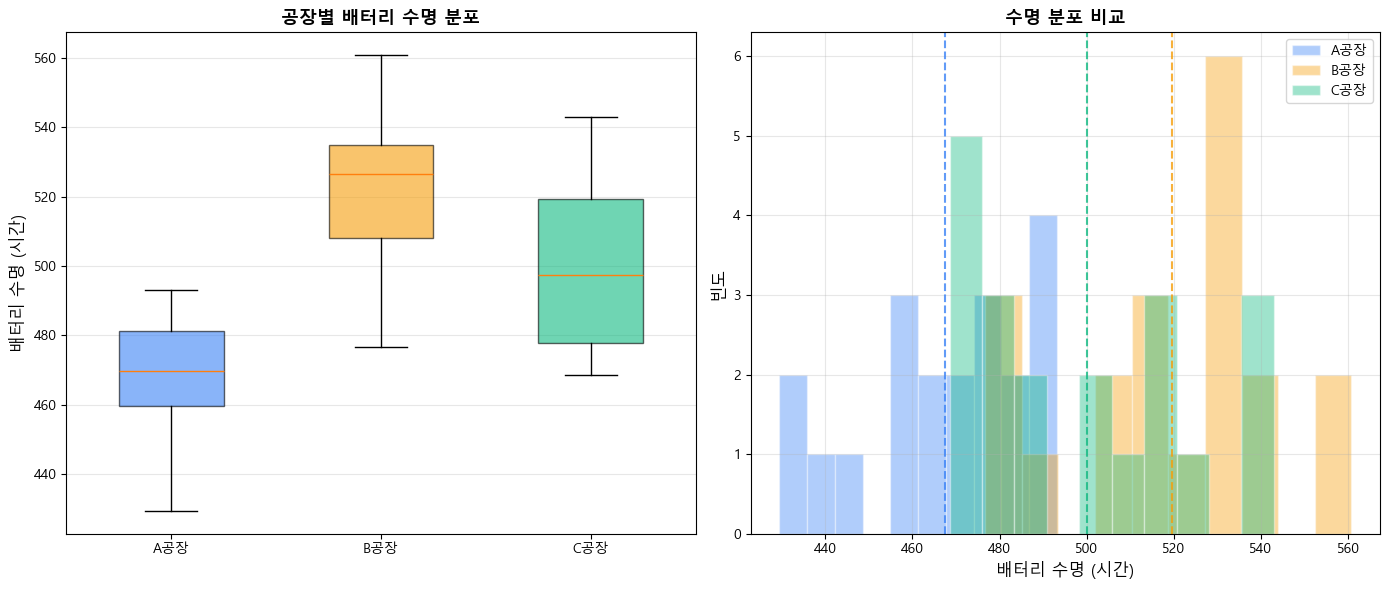

In [3]:
# 분포 시각화: 박스플롯 + 히스토그램
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#3B82F6', '#F59E0B', '#10B981']
bp = axes[0].boxplot([factory_a, factory_b, factory_c],
                      labels=['A공장', 'B공장', 'C공장'],
                      patch_artist=True, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel('배터리 수명 (시간)', fontsize=12)
axes[0].set_title('공장별 배터리 수명 분포', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for data, name, color in [(factory_a, 'A공장', '#3B82F6'),
                           (factory_b, 'B공장', '#F59E0B'),
                           (factory_c, 'C공장', '#10B981')]:
    axes[1].hist(data, bins=10, alpha=0.4, color=color, edgecolor='white', label=name)
    axes[1].axvline(data.mean(), color=color, linestyle='--', alpha=0.8)

axes[1].set_xlabel('배터리 수명 (시간)', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('수명 분포 비교', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 1-1: 가설 설정 및 가정 검정

**(a)** 분석 목표에 맞는 **귀무가설(H₀)** 과 **대립가설(H₁)** 을 수식으로 설정하세요.

**(b)** 각 공장 데이터의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(c)** 3개 공장의 **Q-Q Plot**을 나란히 그리세요.

**(d)** 정규성이 충족된다면, **등분산 검정**(Levene)을 수행하세요.

**(e)** 가정 검정 결과를 종합하여 **어떤 검정을 사용할지** 결정하세요.
의사결정 과정을 단계별로 설명하세요.

> **의사결정 흐름**: 정규성 확인 → (충족 시) 등분산 확인 → 검정 방법 선택

In [4]:
print("\n[문제 1-1] 가설 설정 및 가정 검정")
print("-" * 40)

# display(Math(r'...'))를 사용하면 주피터 노트북에서 LaTeX 수식을 사용할 수 있다고 함
from IPython.display import display, Math

# TODO (a): 가설 설정
# 귀무가설(H₀): 3개 공장에서 생산된 배터리의 평균 수명은 차이가 없을 것이다.
print("(a): 가설 설정")
print("- 귀무가설(H₀): 3개 공장에서 생산된 배터리의 평균 수명은 차이가 없을 것이다.")
print("- 대립가설(H₁): 3개 공장에서 생산된 배터리의 평균 수명은 차이가 있을 것이다.")

display(Math(r"H_0: \mu_A = \mu_B = \mu_C"))
display(Math(r"H_1: \text{세 공장의 데이터 중 적어도 하나의 } \mu_i \text{는 다르다} \quad (i = A, B, C)"))


[문제 1-1] 가설 설정 및 가정 검정
----------------------------------------
(a): 가설 설정
- 귀무가설(H₀): 3개 공장에서 생산된 배터리의 평균 수명은 차이가 없을 것이다.
- 대립가설(H₁): 3개 공장에서 생산된 배터리의 평균 수명은 차이가 있을 것이다.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# TODO (b): Shapiro-Wilk 정규성 검정 (각 공장별)
print("(b): Shapiro-Wilk 정규성 검정 (각 공장별)")
print("-" * 40)

# 각각의 공장에 대해 모두 정규성 검정 실시
factory_data = [factory_a, factory_b, factory_c]
factory_name = ['A공장', 'B공장', 'C공장']

for data, name in zip(factory_data, factory_name):
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f"\n{name}의 Shapiro-Wilk 검정 통계량: {shapiro_stat:.4f}")
    print(f"{name}의 Shapiro-Wilk 검정 시, p-value: {shapiro_p:.4f}")
    
    if shapiro_p > 0.05:
        print("귀무가설을 기각하지 못합니다. -> 정규성을 만족한 것으로 인정합니다.")
    else:
        print("귀무가설을 기각합니다. -> 정규성을 만족하지 못합니다.")    

(b): Shapiro-Wilk 정규성 검정 (각 공장별)
----------------------------------------

A공장의 Shapiro-Wilk 검정 통계량: 0.9210
A공장의 Shapiro-Wilk 검정 시, p-value: 0.1036
귀무가설을 기각하지 못합니다. -> 정규성을 만족한 것으로 인정합니다.

B공장의 Shapiro-Wilk 검정 통계량: 0.9328
B공장의 Shapiro-Wilk 검정 시, p-value: 0.1746
귀무가설을 기각하지 못합니다. -> 정규성을 만족한 것으로 인정합니다.

C공장의 Shapiro-Wilk 검정 통계량: 0.9062
C공장의 Shapiro-Wilk 검정 시, p-value: 0.0540
귀무가설을 기각하지 못합니다. -> 정규성을 만족한 것으로 인정합니다.


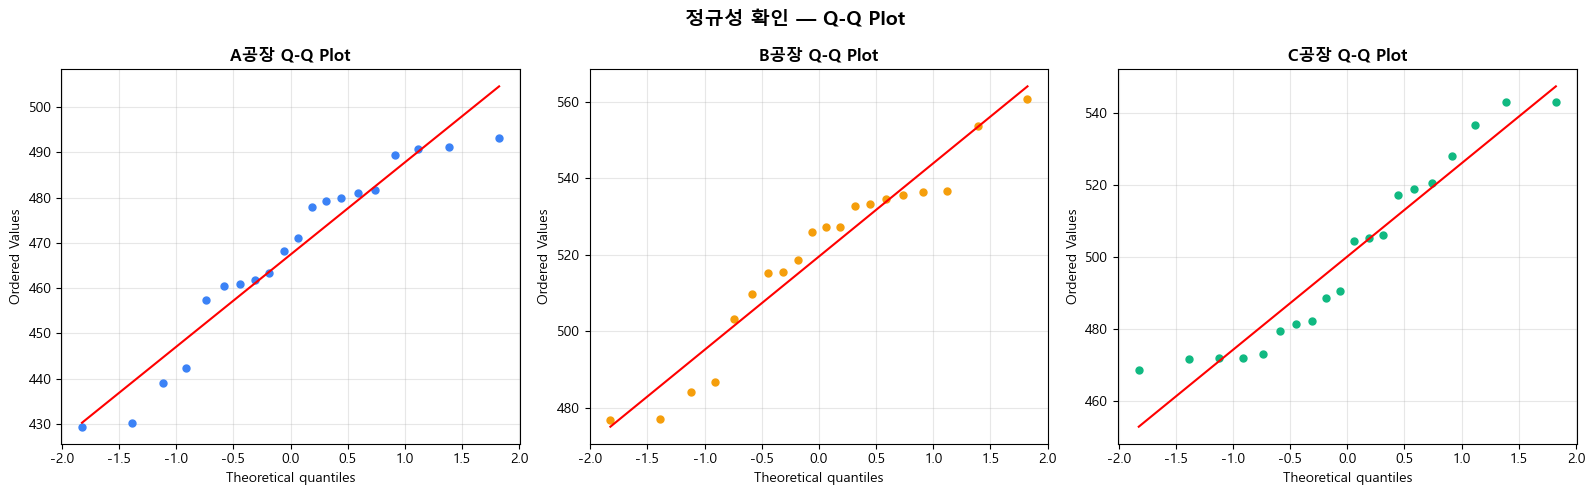

In [6]:
# TODO (c): Q-Q Plot (3개 공장)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("정규성 확인 — Q-Q Plot", fontsize=14, fontweight='bold')

# TODO: 각 공장의 Q-Q Plot 그리기
for ax, data, name, color in [(axes[0], factory_a, 'A공장', '#3B82F6'),
                                (axes[1], factory_b, 'B공장', '#F59E0B'),
                                (axes[2], factory_c, 'C공장', '#10B981')]:
    
    # Q-Q plot
    stats.probplot(data, dist='norm', plot=ax)
    
    # 시각화 옵션
    ax.get_lines()[0].set(color=color, markersize=5) # 점
    ax.get_lines()[1].set(color='red') # 기준선
    ax.set_title(f"{name} Q-Q Plot", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 해석: 세 공장의 제품 데이터는 정규성을 만족한다.

In [7]:
# TODO (d): 등분산 검정 (정규성 충족 시)
print("(d): 등분산 검정 (Levene 검정 수행)")
print("-" * 40)

lev_stat, lev_p = stats.levene(factory_a, factory_b, factory_c)
print(f"Levene 검정 통계량: {lev_stat:.4f}")
print(f"p-value: {lev_p:.4f}")

if lev_p > 0.05:
    print("귀무가설을 기각하지 못합니다. -> 등분산성을 만족한 것으로 인정합니다.")
else:
    print("귀무가설을 기각합니다. -> 등분산성을 만족하지 않습니다.")    

(d): 등분산 검정 (Levene 검정 수행)
----------------------------------------
Levene 검정 통계량: 1.0643
p-value: 0.3517
귀무가설을 기각하지 못합니다. -> 등분산성을 만족한 것으로 인정합니다.


In [8]:
# TODO (e): 검정 방법 결정
print("(e): 검정 방법 결정 과정")
print("-" * 40)

decision_process = """
[Step 1. 정규성 확인]
(1) Shapiro-Wilk 검정을 수행해보니 세 공장의 데이터 모두 p-value가 0.05보다 큼.
(2) Q-Q Plot으로 시각화해보니, 모든 데이터가 각각 직선에 가깝게 배치됨
--> 따라서 세 공장의 데이터는 모두 정규성 가정을 만족한다고 판단함

[Step 2. 등분산성 확인]
(1) 정규성을 만족하므로 Levene 검정 실시
(2) Levene 검정 결과: p-value가 0.3517로 0.05보다 큼
--> 따라서 세 공장의 데이터는 등분산성 가정을 만족한다고 판단함

[Step 3. 검정방법 선택]
(1) 정규성과 등분산성을 모두 만족하는 데이터
--> 모든 가정을 만족하므로 모수 검정 중 하나인 One-way ANOVA 검정 수행
"""

print(decision_process)

(e): 검정 방법 결정 과정
----------------------------------------

[Step 1. 정규성 확인]
(1) Shapiro-Wilk 검정을 수행해보니 세 공장의 데이터 모두 p-value가 0.05보다 큼.
(2) Q-Q Plot으로 시각화해보니, 모든 데이터가 각각 직선에 가깝게 배치됨
--> 따라서 세 공장의 데이터는 모두 정규성 가정을 만족한다고 판단함

[Step 2. 등분산성 확인]
(1) 정규성을 만족하므로 Levene 검정 실시
(2) Levene 검정 결과: p-value가 0.3517로 0.05보다 큼
--> 따라서 세 공장의 데이터는 등분산성 가정을 만족한다고 판단함

[Step 3. 검정방법 선택]
(1) 정규성과 등분산성을 모두 만족하는 데이터
--> 모든 가정을 만족하므로 모수 검정 중 하나인 One-way ANOVA 검정 수행



### 문제 1-2: ANOVA 검정 수행 및 효과크기

**(a)** 1-1에서 결정한 검정을 수행하세요 (α = 0.05).

**(b)** 전체 효과크기(η² 또는 η²_H)를 계산하고 해석하세요.

**(c)** ω²(오메가제곱)을 계산할 수 있다면 함께 보고하세요.

**(d)** 검정 결과(p-value)와 효과크기를 종합하여 결론을 내리세요.

In [9]:
print("\n[문제 1-2] ANOVA 검정 수행 및 효과크기")
print("-" * 40)

# 표본 데이터 생성
groups = ['A공장'] * 20 + ['B공장'] * 20 + ['C공장'] * 20
lifetimes = np.concatenate([factory_a, factory_b, factory_c])
df_battery = pd.DataFrame({'공장': groups, '수명': lifetimes})

print("배터리 데이터 샘플:")
display(df_battery.sample(5))
print("기술통계:")
display(df_battery.describe().round(2))


[문제 1-2] ANOVA 검정 수행 및 효과크기
----------------------------------------
배터리 데이터 샘플:


,공장,수명
52,C공장,506.1
43,C공장,505.3
32,B공장,486.8
21,B공장,536.4
33,B공장,526.0


기술통계:


,수명
count,60.00
mean,495.69
std,31.50
min,429.40
25%,472.72
50%,490.05
75%,521.88
max,560.80


In [10]:
# TODO (a): 검정 수행
print("(a): One-way ANOVA 검정 수행")
print("-" * 40)

alpha = 0.05

anova_f_stat, anova_f_p = stats.f_oneway(factory_a, factory_b, factory_c)

print(f"F통계량: {anova_f_stat:.3f}")
print(f"p-value: {anova_f_p:.3e}")
print(f"유의수준: {alpha}")
print(f"귀무가설 기각 여부: {'p-value가 유의수준보다 작으므로 귀무가설을 기각한다' if anova_f_p < alpha else 'p-value가 유의수준 이상이므로 귀무가설 기각을 보류한다.'}")

(a): One-way ANOVA 검정 수행
----------------------------------------
F통계량: 25.619
p-value: 1.155e-08
유의수준: 0.05
귀무가설 기각 여부: p-value가 유의수준보다 작으므로 귀무가설을 기각한다


In [11]:
# TODO (b): 전체 효과크기
print("(b): 전체 효과크기")
print("-" * 40)

aov = pg.anova(dv='수명',between='공장', data=df_battery, detailed=True)

eta_sq_1 = aov['np2'].values[0]
print(f"η² (에타제곱) = {eta_sq_1:.4f}")

def translate_effect_size(effect_size, metric='η²'):
    if effect_size > 0.14:
        return f"효과크기({metric})는 {effect_size:.4f}로 큰 수준이다."
    elif effect_size > 0.06:
        return f"효과크기({metric})는 {effect_size:.4f}로 중간 수준이다."
    elif effect_size > 0.01:
        return f"효과크기({metric})는 {effect_size:.4f}로 작은 수준이다."
    else:
        return f"효과크기({metric})는 {effect_size:.4f}로 매우 작은 수준이다."
    
print(f"효과크기 해석: {translate_effect_size(eta_sq_1)}")

(b): 전체 효과크기
----------------------------------------
η² (에타제곱) = 0.4734
효과크기 해석: 효과크기(η²)는 0.4734로 큰 수준이다.


In [12]:
# TODO (c): ω² (적절한 검정인 경우)
print("(c): ω² (적절한 검정인 경우)")
print("-" * 40)

# 집단 간 제곱합
ss_b = aov['SS'].values[0]
# 집단 내 제곱합             
ss_w = aov['SS'].values[1] 
# 집단 간 자유도
df_b = aov['DF'].values[0] 
# 집단 내 평균제곱                       
ms_w = aov['MS'].values[1]  
# 총 제곱합                            
ss_t = ss_b + ss_w          
                        
omega_sq_1 = (ss_b - df_b * ms_w) / (ss_t + ms_w)
print(f"ω² (오메가제곱) = {omega_sq_1:.4f}")
print(f"효과크기 해석: {translate_effect_size(omega_sq_1, metric='ω²')}")

(c): ω² (적절한 검정인 경우)
----------------------------------------
ω² (오메가제곱) = 0.4507
효과크기 해석: 효과크기(ω²)는 0.4507로 큰 수준이다.


In [13]:
# TODO (d): 종합 결론
print("(d): 종합 결론")
print("-" * 40)

my_opinion_1 = f""" 세 공장에서 만들어진 배터리의 평균 수명은 모두 같다는 귀무가설은 p-value가 유의수준 미만이므로 기각하고,
각각의 공장에서 만들어진 배터리의 평균 수명 중 적어도 하나 이상의 배터리의 평균 수명이 다를 것으로 사료된다.
또한, 효과크기는 η²={eta_sq_1:.4f}, ω²={omega_sq_1:.4f}로 모두 Cohen의 기준 상으로는 큰 효과를 갖고 있는 것에 해당된다.
따라서 각각의 세 공장에서 생산된 배터리의 평균 수명 차이는 통계적으로 유의하고, 실질적으로도 의미 있는 차이를 보일 것으로 예상된다.
"""

print(my_opinion_1)

(d): 종합 결론
----------------------------------------
 세 공장에서 만들어진 배터리의 평균 수명은 모두 같다는 귀무가설은 p-value가 유의수준 미만이므로 기각하고,
각각의 공장에서 만들어진 배터리의 평균 수명 중 적어도 하나 이상의 배터리의 평균 수명이 다를 것으로 사료된다.
또한, 효과크기는 η²=0.4734, ω²=0.4507로 모두 Cohen의 기준 상으로는 큰 효과를 갖고 있는 것에 해당된다.
따라서 각각의 세 공장에서 생산된 배터리의 평균 수명 차이는 통계적으로 유의하고, 실질적으로도 의미 있는 차이를 보일 것으로 예상된다.



### 문제 1-3: 사후검정 — 어떤 공장 쌍이 다른가?

ANOVA가 유의하다면, **"적어도 하나가 다르다"** 는 것만 알 수 있습니다.
**어떤 공장 쌍**이 다른지 확인하려면 사후검정이 필요합니다.

**(a)** 사용한 검정 방법에 맞는 사후검정을 수행하세요.

> | 검정 방법 | 사후검정 |
> |-----------|---------|
> | One-way ANOVA | Tukey HSD |
> | Welch's ANOVA | Games-Howell |
> | Kruskal-Wallis | Dunn 검정 (Bonferroni 보정) |

**(b)** 쌍별 효과크기를 계산하세요.

> - Tukey HSD 후 → Cohen's d (`pg.compute_effsize(x, y, eftype='cohen')`)
> - Games-Howell 후 → Hedges' g (`pg.compute_effsize(x, y, eftype='hedges')`)
> - Dunn 검정 후 → 중앙값 차이로 방향과 크기 해석

**(c)** 사후검정 결과를 종합하여, 구체적으로 어떤 공장이 어떻게 다른지 해석하세요.

**(d)** 공장별 평균 배터리 수명을 막대 그래프(±SEM 오차막대 포함)로 시각화하세요.

In [14]:
print("\n[문제 1-3] 사후검정")
print("-" * 40)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# TODO (a): 사후검정 수행
print("(a): Tukey-HSD 사후검정 수행 결과")
print("-" * 40)

alpha = 0.05

tukey_table = pairwise_tukeyhsd(endog=df_battery['수명'], groups=df_battery['공장'], alpha=alpha)

print(tukey_table)


[문제 1-3] 사후검정
----------------------------------------
(a): Tukey-HSD 사후검정 수행 결과
----------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   A공장    B공장   52.085    0.0  34.3875 69.7825   True
   A공장    C공장    32.66 0.0001  14.9625 50.3575   True
   B공장    C공장  -19.425 0.0283 -37.1225 -1.7275   True
-----------------------------------------------------


In [15]:
# TODO (b): 쌍별 효과크기
print("(b): 쌍별 효과크기")
print("-" * 40)

# df_battery['공장'].unique(): 고유값을 반환하는 메서드
pairs_of_factories = list(combinations(df_battery['공장'].unique(), 2))

def translate_cohens_d(cohens_d):
    if abs(cohens_d) > 0.8:
        return '효과크기가 큰 편이다.'
    elif abs(cohens_d) > 0.5:
        return '효과크기가 중간인 편이다.'
    elif abs(cohens_d) > 0.2:
        return '효과크기가 작은 편이다.'
    else:
        return '효과크기가 매우 작은 편이다.'

for fac_1, fac_2 in pairs_of_factories:
    
    # 쌍별 효과크기 계산 -> 해석
    x = df_battery[df_battery['공장'] == fac_1]['수명']
    y = df_battery[df_battery['공장'] == fac_2]['수명']
    cohens_d = pg.compute_effsize(x, y, eftype='cohen')

    print(f"{fac_1}와 {fac_2}의 쌍별 효과크기는 {cohens_d:.3f}으로 {translate_cohens_d(cohens_d)}")

(b): 쌍별 효과크기
----------------------------------------
A공장와 B공장의 쌍별 효과크기는 -2.367으로 효과크기가 큰 편이다.
A공장와 C공장의 쌍별 효과크기는 -1.423으로 효과크기가 큰 편이다.
B공장와 C공장의 쌍별 효과크기는 0.785으로 효과크기가 중간인 편이다.


In [16]:
# TODO (c): 종합 해석
print("(c): 종합 해석")
print("-" * 40)

my_opinion_2 = """Tukey HSD 사후 검정에서 세 공장 간 모든 쌍 ((A, B), (A, C), (B, C))의 p-value가 유의수준(0.05) 미만으로,
세 공장 간 배터리 평균 수명 차이는 모두 통계적으로 유의한 것으로 판단된다.

Tukey HSD 사후 검정 결과에서 'meandiff' 열을 보면 
(A, B), (A, C) 비교를 통해 A공장에서 생산된 배터리의 평균 수명이 가장 짧고,
(B, C) 비교를 통해 B공장에서 생산된 배터리의 평균 수명이 C공장보다 긴 것을 확인할 수 있다.
이는 (A, B), (A, C) 쌍의 효과크기인 Cohen's d가 음수인 것을 통해 뒷받침된다.

따라서 세 공장의 배터리 평균 수명은 A공장에서 가장 짧고,
B공장에서 가장 긴 경향이 있는 것으로 사료된다. (B > C > A)
"""

print(my_opinion_2)

(c): 종합 해석
----------------------------------------
Tukey HSD 사후 검정에서 세 공장 간 모든 쌍 ((A, B), (A, C), (B, C))의 p-value가 유의수준(0.05) 미만으로,
세 공장 간 배터리 평균 수명 차이는 모두 통계적으로 유의한 것으로 판단된다.

Tukey HSD 사후 검정 결과에서 'meandiff' 열을 보면 
(A, B), (A, C) 비교를 통해 A공장에서 생산된 배터리의 평균 수명이 가장 짧고,
(B, C) 비교를 통해 B공장에서 생산된 배터리의 평균 수명이 C공장보다 긴 것을 확인할 수 있다.
이는 (A, B), (A, C) 쌍의 효과크기인 Cohen's d가 음수인 것을 통해 뒷받침된다.

따라서 세 공장의 배터리 평균 수명은 A공장에서 가장 짧고,
B공장에서 가장 긴 경향이 있는 것으로 사료된다. (B > C > A)



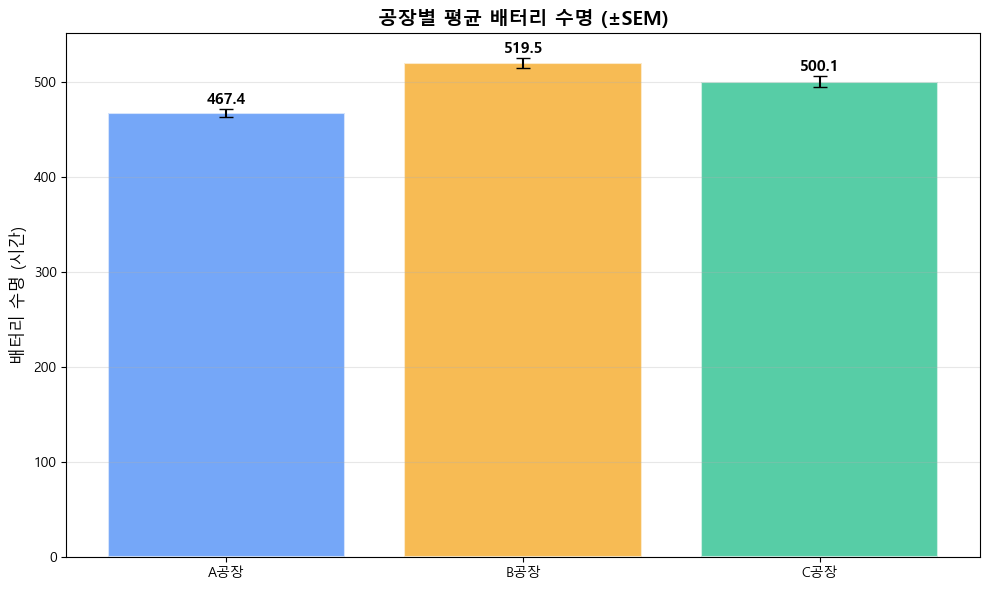

In [17]:
# TODO (d): 막대 그래프 (±SEM)
fig, ax = plt.subplots(figsize=(10, 6))

group_data = {
    'A공장': factory_a,
    'B공장': factory_b,
    'C공장': factory_c,
}

colors = ['#3B82F6', '#F59E0B', '#10B981']

means = [d.mean() for d in group_data.values()]
sems = [d.std(ddof=1) / np.sqrt(len(d)) for d in group_data.values()]

# TODO: 막대 그래프 + 오차막대 + 평균값 텍스트 표시
bars = ax.bar(group_data.keys(), means, yerr=sems, capsize=5,
            color=colors, alpha=0.7, edgecolor='white', linewidth=1.5)
for bar, mean, sem in zip(bars, means, sems):
    ax.text(bar.get_x() + bar.get_width()/2., mean + sem + 1,
            f'{mean:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('배터리 수명 (시간)', fontsize=12)
ax.set_title('공장별 평균 배터리 수명 (±SEM)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 문제 2: 직원 데이터 상관분석

한 IT 기업에서 직원 30명의 데이터를 수집했습니다.
경력(년), 월급여(만원), 프로젝트 완료 수, 직무 만족도(1~10점)의 관계를 분석합니다.

**분석 목표**:
- 변수 간 상관관계를 파악하고, 어떤 변수 쌍이 유의한 상관을 보이는지 확인합니다.
- Pearson과 Spearman 상관계수를 비교하여 데이터의 특성을 파악합니다.

**주어진 데이터:**

In [18]:
print("\n[문제 2] 직원 데이터 상관분석")
print("=" * 50)

np.random.seed(552)
n_emp = 30

experience = np.round(np.random.uniform(1, 15, n_emp), 1)
salary = np.round(2500 + 180 * experience + np.random.normal(0, 400, n_emp), 0)
projects = np.round(np.clip(2 + 0.8 * experience + np.random.normal(0, 3, n_emp), 0, 30), 0).astype(int)
satisfaction = np.round(np.clip(4 + 0.3 * experience - 0.0005 * salary + np.random.normal(0, 1.8, n_emp), 1, 10), 1)

df_emp = pd.DataFrame({
    '경력(년)': experience,
    '월급여(만원)': salary,
    '프로젝트수': projects,
    '만족도': satisfaction
})
print("직원 데이터 샘플:")
display(df_emp.sample(5))
print("기술통계:")
display(df_emp.describe().round(2))


[문제 2] 직원 데이터 상관분석
직원 데이터 샘플:


,경력(년),월급여(만원),프로젝트수,만족도
23,8.7,4354.0,15,6.3
3,12.2,4357.0,11,6.9
15,8.8,4159.0,11,5.3
24,5.8,2343.0,5,8.6
4,3.8,3216.0,3,4.1


기술통계:


,경력(년),월급여(만원),프로젝트수,만족도
count,30.00,30.00,30.00,30.00
mean,8.69,3973.30,9.03,4.49
std,4.07,871.03,4.86,2.04
min,1.80,2094.00,0.00,1.00
25%,5.72,3248.00,6.00,3.02
50%,8.75,4045.00,8.50,4.05
75%,12.15,4703.50,13.75,6.20
max,14.60,5378.00,19.00,8.60


### 문제 2-1: 산점도와 상관 행렬

**(a)** `경력(년)`과 `월급여(만원)`의 산점도를 그리고, 회귀선을 추가하세요.
시각적으로 어떤 관계가 보이는지 서술하세요.

**(b)** 전체 변수의 **Pearson 상관 행렬**을 계산하고 히트맵으로 시각화하세요.

> `df_emp.corr(method='pearson')` + `seaborn.heatmap()`

**(c)** 전체 변수의 **Spearman 상관 행렬**도 함께 히트맵으로 그려서 나란히 비교하세요.


[문제 2-1] 산점도와 상관 행렬
----------------------------------------


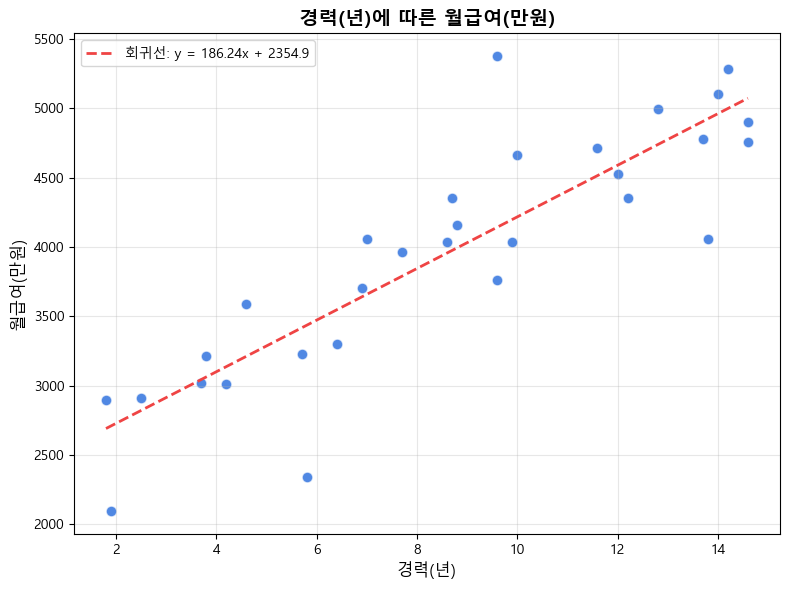

(a) 시각화 결과 관찰 결과 해석
 - 경력이 증가할수록 월급여(만원)도 증가하는 관계가 관찰된다.


In [19]:
print("\n[문제 2-1] 산점도와 상관 행렬")
print("-" * 40)

# TODO (a): 경력 vs 월급여 산점도 + 회귀선
fig, ax = plt.subplots(figsize=(8,6))

# 산점도
ax.scatter(x=df_emp['경력(년)'], y=df_emp['월급여(만원)'], color="#0656D8", alpha=0.7, s=60, edgecolors='white')

# 회귀선
z = np.polyfit(df_emp['경력(년)'], df_emp['월급여(만원)'], 1)
p = np.poly1d(z)
x_line = np.linspace(df_emp['경력(년)'].min(), df_emp['경력(년)'].max(), 100)
ax.plot(x_line, p(x_line), color='#EF4444', linewidth=2, linestyle='--',
        label=f'회귀선: y = {z[0]:.2f}x + {z[1]:.1f}')

# 시각화
ax.set_xlabel('경력(년)', fontsize=12)
ax.set_ylabel('월급여(만원)', fontsize=12)
ax.set_title('경력(년)에 따른 월급여(만원)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("(a) 시각화 결과 관찰 결과 해석")
print(f" - 경력이 증가할수록 월급여(만원)도 증가하는 관계가 관찰된다.")

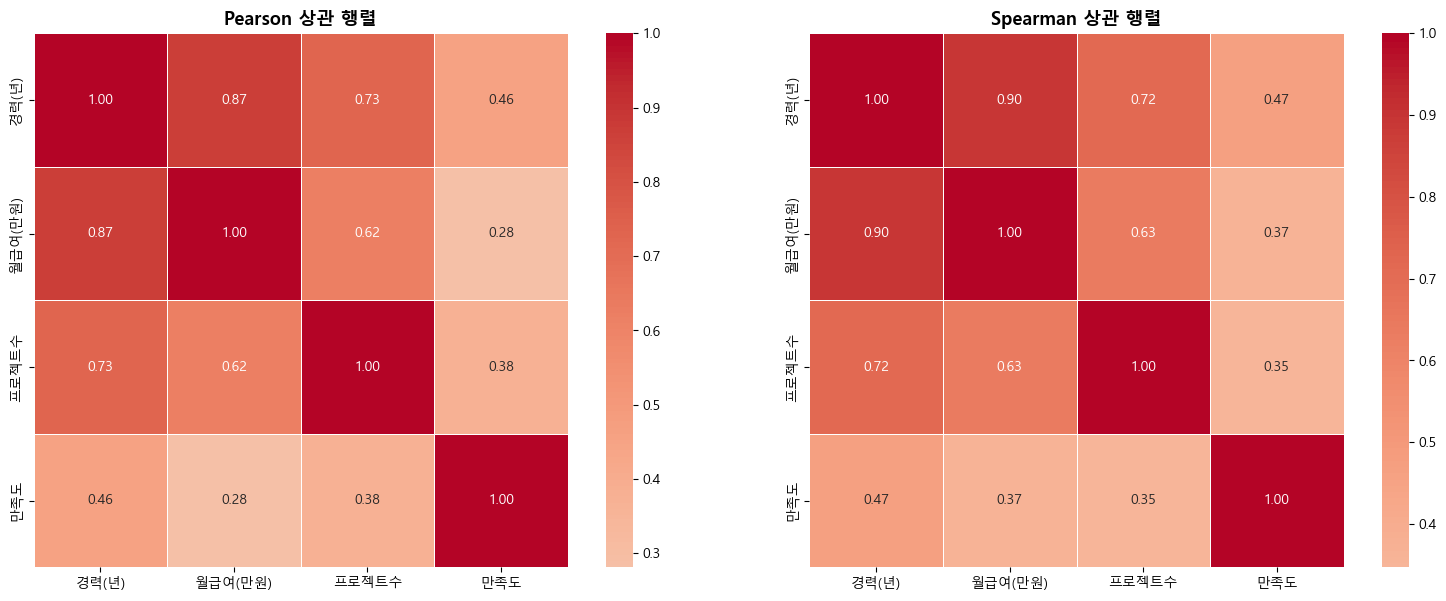

In [20]:
# Pearson vs Spearman 상관 히트맵

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# TODO (b): Pearson 상관 행렬 히트맵
# 피어슨 상관행렬 계산
corr_matrix_p = df_emp.corr(method='pearson')

# 피어슨 상관행렬 히트맵 제작
sns.heatmap(corr_matrix_p, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Pearson 상관 행렬', fontsize=13, fontweight='bold')

# TODO (c): Spearman 상관 행렬 히트맵
# 스피어만 상관행렬 계산
corr_matrix_s = df_emp.corr(method='spearman')

# 스피어만 상관행렬 히트맵 제작
sns.heatmap(corr_matrix_s, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Spearman 상관 행렬', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

### 문제 2-2: 상관계수 가설검정

**(a)** `경력(년)`과 `월급여(만원)` 사이의 **Pearson 상관계수**와 **p-value**를 구하세요.

**(b)** 같은 변수 쌍에 대해 **Spearman 상관계수**와 **p-value**를 구하세요.

**(c)** 두 상관계수를 비교하세요. 차이가 크다면/작다면 어떤 의미인지 설명하세요.

In [21]:
print("\n[문제 2-2] 상관계수 가설검정")
print("-" * 40)

# TODO (a): Pearson 상관계수
print(f"(a) Pearson 상관계수")
print("-" * 40)

pearson_r, pearson_p = stats.pearsonr(df_emp['경력(년)'], df_emp['월급여(만원)'])

print(f"경력(년)과 월급여(만원) 사이의 Pearson 상관계수: {pearson_r:.4f}")
print(f"경력(년)과 월급여(만원) 사이의 p-value: {pearson_p:.4e}")


[문제 2-2] 상관계수 가설검정
----------------------------------------
(a) Pearson 상관계수
----------------------------------------
경력(년)과 월급여(만원) 사이의 Pearson 상관계수: 0.8701
경력(년)과 월급여(만원) 사이의 p-value: 4.2205e-10


In [22]:
# TODO (b): Spearman 상관계수
print(f"\n(b) Spearman 상관계수")
print("-" * 40)

spearman_rho, spearman_p = stats.spearmanr(df_emp['경력(년)'], df_emp['월급여(만원)'])

print(f"경력(년)과 월급여(만원) 사이의 Spearman 상관계수: {spearman_rho:.4f}")
print(f"경력(년)과 월급여(만원) 사이의 p-value: {spearman_p:.4e}")


(b) Spearman 상관계수
----------------------------------------
경력(년)과 월급여(만원) 사이의 Spearman 상관계수: 0.8965
경력(년)과 월급여(만원) 사이의 p-value: 2.0766e-11


In [23]:
# TODO (c): 비교
print(f"\n(c) Pearson vs Spearman 비교")
print("-" * 40)

if abs(pearson_r - spearman_rho) < 0.01:
    compared = "스피어만 상관계수와 피어슨 상관계수의 차이는 0.01 미만으로 거의 존재하지 않음"
    conclusion = "경력(년)과 월급여(만원)의 관계는 선형에 가깝다."
elif pearson_r < spearman_rho:
    compared = "스피어만 상관계수 > 피어슨 상관계수"
    conclusion = "경력(년)과 월급여(만원)의 관계는 비선형이고, 단조적 관계가 존재한다."    
elif pearson_r > spearman_rho:
    compared = "스피어만 상관계수 < 피어슨 상관계수"
    conclusion = "이상치가 피어슨 상관계수를 부풀렸을 가능성을 배제할 수 없다."    

print(f"비교: {compared}")
print(f"해석: {conclusion}")


(c) Pearson vs Spearman 비교
----------------------------------------
비교: 스피어만 상관계수 > 피어슨 상관계수
해석: 경력(년)과 월급여(만원)의 관계는 비선형이고, 단조적 관계가 존재한다.


### 문제 2-3: 다변량 상관분석과 해석

**(a)** `pg.pairwise_corr(df_emp, method='pearson')`으로 모든 변수 쌍의 상관분석을 수행하세요.
유의한 상관(p < 0.05)을 보이는 쌍을 모두 찾으세요.

**(b)** 유의한 상관을 보이는 변수 쌍 중에서, **상관이 인과를 의미하지 않는** 예시를 하나 들고,
왜 인과라고 할 수 없는지 교란변수의 가능성을 포함하여 설명하세요.

> **상관 vs 인과**: 두 변수가 함께 움직여도(상관), 한 변수가 다른 변수를 변화시킨다(인과)고
> 단정할 수 없습니다. 인과를 확인하려면 **실험(RCT, A/B 테스트)** 이 필요합니다.

**(c)** 만약 `경력`과 `만족도` 사이에 유의한 상관이 있다면,
"경력이 많을수록 만족도가 높다"고 결론 내릴 수 있나요?
왜 그런지/아닌지 교란변수(예: 직급, 급여, 업무 환경)의 관점에서 논의하세요.

In [24]:
print("\n[문제 2-3] 다변량 상관분석과 해석")
print("-" * 40)

# TODO (a): pairwise_corr
print(f"(a-1) 모든 순서쌍의 피어슨 상관분석 결과")

# 모든 변수 쌍 Pearson 상관분석 수행
pearson_result = pg.pairwise_corr(df_emp, method='pearson')
display(pearson_result)

# 유의한 상관 쌍 필터링 (p < 0.05)
meaningful_pairs = pearson_result[pearson_result['p-unc'] < 0.05]

# 유의한 쌍의 변수명 출력
answer = meaningful_pairs[['X', 'Y']]

print(f"(a-2) p-value가 0.05 미만인 (X, Y)쌍")
print(answer)


[문제 2-3] 다변량 상관분석과 해석
----------------------------------------
(a-1) 모든 순서쌍의 피어슨 상관분석 결과


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,경력(년),월급여(만원),pearson,two-sided,30,0.870138,"[0.74, 0.94]",4.220485e-10,2.496e+07,1.000000
1,경력(년),프로젝트수,pearson,two-sided,30,0.731927,"[0.5, 0.86]",4.297150e-06,5280.265,0.998403
2,경력(년),만족도,pearson,two-sided,30,0.456776,"[0.12, 0.7]",1.116697e-02,4.899,0.738737
3,월급여(만원),프로젝트수,pearson,two-sided,30,0.620774,"[0.34, 0.8]",2.520477e-04,134.422,0.968911
4,월급여(만원),만족도,pearson,two-sided,30,0.281184,"[-0.09, 0.58]",1.322659e-01,0.67,0.331057
5,프로젝트수,만족도,pearson,two-sided,30,0.376189,"[0.02, 0.65]",4.047426e-02,1.683,0.549764


(a-2) p-value가 0.05 미만인 (X, Y)쌍
         X        Y
0    경력(년)  월급여(만원)
1    경력(년)    프로젝트수
2    경력(년)      만족도
3  월급여(만원)    프로젝트수
5    프로젝트수      만족도


In [25]:
# TODO (b): 상관 vs 인과 — 교란변수 논의
my_opinion_3 = """ p-value가 0.05 미만으로, 유의미한 상관관계를 보인 변수쌍은 총 5개이다.
그렇다면 이 모든 변수쌍이 유의미한 상관관계를 갖고 있다고, 인과관계도 갖고 있다고 할 수 있을까?
나는 그렇지 않다고 생각한다.

예를 들어 '경력 <-> 프로젝트수'를 살펴보자. 경력이 많기 때문에 프로젝트를 많이 수행한다고 보기 어렵다.
왜냐하면 경력이 많다는 것은 직급이 높거나 업무 능력이 경력이 적은 사람보다 우수할 가능성이 높은데, 이로 인해
경력이 많은 사람이 프로젝트를 많이 맡은 것일 수 있기 때문이다. 이와 같이 경력이 많다는 것이 직접적으로 프로젝트 수에
영향을 준다고 해석하기에는 두 변수 사이에 존재하는 교란변수들을 고려하면 우리는 상관관계를 갖는다고 무조건 인과관계를
갖는다고 할 수 없다는 것을 알 수 있다.

따라서 우리는 두 변수 간의 인과관계를 확인하기 위해서는 A/B테스트와 같은 실험을 수행해야 한다.
"""

print(f"(b) 상관관계를 갖는다고, 인과관계를 갖는다고 할 수 있을까?")
print("-" * 40)
print(my_opinion_3)

(b) 상관관계를 갖는다고, 인과관계를 갖는다고 할 수 있을까?
----------------------------------------
 p-value가 0.05 미만으로, 유의미한 상관관계를 보인 변수쌍은 총 5개이다.
그렇다면 이 모든 변수쌍이 유의미한 상관관계를 갖고 있다고, 인과관계도 갖고 있다고 할 수 있을까?
나는 그렇지 않다고 생각한다.

예를 들어 '경력 <-> 프로젝트수'를 살펴보자. 경력이 많기 때문에 프로젝트를 많이 수행한다고 보기 어렵다.
왜냐하면 경력이 많다는 것은 직급이 높거나 업무 능력이 경력이 적은 사람보다 우수할 가능성이 높은데, 이로 인해
경력이 많은 사람이 프로젝트를 많이 맡은 것일 수 있기 때문이다. 이와 같이 경력이 많다는 것이 직접적으로 프로젝트 수에
영향을 준다고 해석하기에는 두 변수 사이에 존재하는 교란변수들을 고려하면 우리는 상관관계를 갖는다고 무조건 인과관계를
갖는다고 할 수 없다는 것을 알 수 있다.

따라서 우리는 두 변수 간의 인과관계를 확인하기 위해서는 A/B테스트와 같은 실험을 수행해야 한다.



In [26]:
# TODO (c): 경력 vs 만족도 해석
my_opinion_4 = """ p-value가 0.05 미만으로, 유의미한 상관관계를 보인 변수쌍 중 (경력, 만족도)가 존재한다.
그렇다면 경력이 높아질수록 만족도가 높다고 할 수 있을까? 나는 그렇지 않다고 생각한다.

왜냐라면 경력과 만족도 사이에는 다양한 교란변수가 존재하기 때문이다. 무조건 경력이 높으면 만족도가 상승한다고 보기 어려운 이유는 다음과 같다.
첫째, 경력이 많으면 자연스레 월급이 올라가는 경우가 많다. 이로 인해 개인의 만족도는 상승할 수 있다고 생각한다.
둘째, 경력이 많으면 직급이 점점 올라가게 되고, 직급이 올라가면 업무 자율성이 높아지는 경우가 많다. 이로 인해 개인의 만족도는 상승할 수 있다고 생각한다.

이처럼 단순히 경력이 많아지면서 만족도가 상승한다고 해석하기에는 개인의 만족도에 영향을 줄 수 있는 요인은 너무나도 다양하다.
따라서 경력과 만족도는 직접적인 인과관계를 갖는다고 해석하기 어렵다.
"""

print(f"(c): 경력 vs 만족도 해석")
print("-" * 40)
print(my_opinion_4)

(c): 경력 vs 만족도 해석
----------------------------------------
 p-value가 0.05 미만으로, 유의미한 상관관계를 보인 변수쌍 중 (경력, 만족도)가 존재한다.
그렇다면 경력이 높아질수록 만족도가 높다고 할 수 있을까? 나는 그렇지 않다고 생각한다.

왜냐라면 경력과 만족도 사이에는 다양한 교란변수가 존재하기 때문이다. 무조건 경력이 높으면 만족도가 상승한다고 보기 어려운 이유는 다음과 같다.
첫째, 경력이 많으면 자연스레 월급이 올라가는 경우가 많다. 이로 인해 개인의 만족도는 상승할 수 있다고 생각한다.
둘째, 경력이 많으면 직급이 점점 올라가게 되고, 직급이 올라가면 업무 자율성이 높아지는 경우가 많다. 이로 인해 개인의 만족도는 상승할 수 있다고 생각한다.

이처럼 단순히 경력이 많아지면서 만족도가 상승한다고 해석하기에는 개인의 만족도에 영향을 줄 수 있는 요인은 너무나도 다양하다.
따라서 경력과 만족도는 직접적인 인과관계를 갖는다고 해석하기 어렵다.



---

## 문제 3: 앱 UI 변경 A/B 테스트 (전환율 비교)

모바일 쇼핑 앱에서 결제 화면 UI를 개선하면 **구매 전환율**이 높아지는지 A/B 테스트를 수행합니다.

- **대조군(A)**: 기존 결제 화면
- **실험군(B)**: 개선된 결제 화면 (버튼 크기 확대 + 단계 축소)
- **지표**: 구매 전환율 (결제 완료 비율)
- **현재 전환율**: 8%
- **비즈니스 목표**: 최소 2%p 이상 개선을 탐지하고 싶음 (8% → 10%)

**분석 목표**: 개선된 UI가 기존 대비 전환율을 유의하게 높이는지 검정합니다.

---

### 문제 3-1: 실험 설계 — 표본 크기 산정

A/B 테스트를 실행하기 **전에** 필요한 표본 크기를 산정합니다.

**(a)** 실험 설계 파라미터를 정리하세요.

**(b)** **효과크기(Cohen's h)** 를 계산하세요.

**(c)** **집단당 필요 표본 크기**를 산정하세요.

**(d)** 양측검정과 단측검정 각각에 대해 표본 크기를 구하고, 차이를 비교하세요.
이 실험에서는 어떤 검정이 더 적절한지 근거와 함께 설명하세요.

In [27]:
print("\n[문제 3] 앱 UI 변경 A/B 테스트")
print("=" * 50)
print("\n[문제 3-1] 실험 설계 — 표본 크기 산정")
print("-" * 40)

baseline_rate = 0.08   # 기존 전환율
mde = 0.02             # 최소 탐지 효과 (2%p)
alpha = 0.05           # 유의수준
power_target = 0.80    # 검정력

target_rate = baseline_rate + mde  # 목표 전환율

# TODO (a): 파라미터 정리
print("(a): 파라미터 정리")
print("-" * 40)
print(f"  기존 전환율 (p₀): {baseline_rate:.0%}")
print(f"  목표 전환율 (p₁): {target_rate:.0%}")
print(f"  MDE (최소 탐지 효과): {mde:.0%}p")
print(f"  유의수준: {alpha}")
print(f"  검정력: {power_target:.0%}")


[문제 3] 앱 UI 변경 A/B 테스트

[문제 3-1] 실험 설계 — 표본 크기 산정
----------------------------------------
(a): 파라미터 정리
----------------------------------------
  기존 전환율 (p₀): 8%
  목표 전환율 (p₁): 10%
  MDE (최소 탐지 효과): 2%p
  유의수준: 0.05
  검정력: 80%


In [28]:
# TODO (b): 효과크기 (Cohen's h)
print("(b): 효과크기 (Cohen's h)")
print("-" * 40)

effect_size = abs(proportion_effectsize(target_rate, baseline_rate))

print(f"  효과크기 (Cohen's h): {effect_size:.2f}")

(b): 효과크기 (Cohen's h)
----------------------------------------
  효과크기 (Cohen's h): 0.07


In [29]:
# TODO (c): 필요 표본 크기
print("(c): 표본 크기 산정")
print("-" * 40)

# NormalIndPower: 정규분포 기반 독립 표본 검정력 분석 클래스
power_analysis = NormalIndPower()
sample_size_two_sides = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power_target,
    alternative='two-sided'
)

print(f"  집단당 필요한 표본 크기(양측검정): {np.ceil(sample_size_two_sides):,.0f}명")

(c): 표본 크기 산정
----------------------------------------
  집단당 필요한 표본 크기(양측검정): 3,205명


In [30]:
# TODO (d): 양측 vs 단측 비교 및 선택
print("(d): 양측 vs 단측 비교 및 선택")
print("-" * 40)

# 단측검정 목적: 결제 화면을 개선하면 전환율이 기존보다 높아지는가?
sample_size_larger = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power_target,
    alternative='larger'
)

print(f"  집단당 필요한 표본 크기(단측검정): {np.ceil(sample_size_larger):,.0f}명")
print(f"  집단당 필요한 표본 크기(양측검정): {np.ceil(sample_size_two_sides):,.0f}명")

my_opinion_5 = f"""\n--> 단측검정을 하면 표본크기를 줄일 수 있기 때문에 의사결정을 위해 필요한 비용을 줄이는 효과를 얻을 수 있을 것이라 생각한다.
그러나 표본의 크기를 줄임으로써 얻는 이득보다는 실제 경향을 더 많이 반영할 수 있는 분석을 통해 내리는 의사결정이 더 중요하다고 생각한다.
단측검정을 사용하면 표본의 수를 줄일 수 있긴 하지만, 결제화면을 개선함으로써 반드시 구매전환율이 높아지거나 낮아진다는 가정을 이미 내포하고 있는 것이기 때문에
실제 경향을 모르는 상황에서는 오히려 독이 될 수 있는 선택이라고 생각한다.
따라서 표본의 수는 더 많더라도 구매전환율의 상승과 하락을 동시에 고려할 수 있는 양측검정을 선택하는 것이 좋다고 생각한다.
"""

print(my_opinion_5)


(d): 양측 vs 단측 비교 및 선택
----------------------------------------
  집단당 필요한 표본 크기(단측검정): 2,525명
  집단당 필요한 표본 크기(양측검정): 3,205명

--> 단측검정을 하면 표본크기를 줄일 수 있기 때문에 의사결정을 위해 필요한 비용을 줄이는 효과를 얻을 수 있을 것이라 생각한다.
그러나 표본의 크기를 줄임으로써 얻는 이득보다는 실제 경향을 더 많이 반영할 수 있는 분석을 통해 내리는 의사결정이 더 중요하다고 생각한다.
단측검정을 사용하면 표본의 수를 줄일 수 있긴 하지만, 결제화면을 개선함으로써 반드시 구매전환율이 높아지거나 낮아진다는 가정을 이미 내포하고 있는 것이기 때문에
실제 경향을 모르는 상황에서는 오히려 독이 될 수 있는 선택이라고 생각한다.
따라서 표본의 수는 더 많더라도 구매전환율의 상승과 하락을 동시에 고려할 수 있는 양측검정을 선택하는 것이 좋다고 생각한다.



### 문제 3-2: A/B 테스트 실행 및 검정

실험을 진행하여 아래 데이터를 수집했습니다.

**(a)** 각 집단의 전환율을 계산하세요.

**(b)** **z-비율검정**을 수행하세요.

> `proportions_ztest(count, nobs, alternative=...)`

**(c)** **효과크기(Cohen's h)** 를 관측된 전환율로 계산하세요.

**(d)** 각 집단의 **95% 신뢰구간**을 구하세요.

> `proportion_confint(count, nobs, alpha=0.05, method='wilson')`

**(e)** **비율 차이의 95% 신뢰구간**을 구하세요.

> `confint_proportions_2indep(count1, nobs1, count2, nobs2, method='wald')`

**(f)** **상대적 개선율(Relative Lift)** 을 계산하세요.

> 상대적 개선율 = (실험군 전환율 − 대조군 전환율) / 대조군 전환율 × 100

**(g)** 전환율 비교 막대 그래프를 그리세요 (95% 신뢰구간 포함).

In [31]:
print("\n[문제 3-2] A/B 테스트 실행 및 검정")
print("-" * 40)

np.random.seed(553)
n_per_group = 2600  # 실험에 참여한 인원 (집단당)

# 데이터 생성 (시뮬레이션)
control_conv = np.random.binomial(1, 0.08, n_per_group)    # 대조군: 8%
treatment_conv = np.random.binomial(1, 0.105, n_per_group)  # 실험군: 10.5%

# TODO (a): 전환율 계산
print("(a): 각 집단의 전환율 계산")
print("-" * 40)

# 구매 전환율(CVR)
cvr_of_control_groups = control_conv.mean() # 대조군
cvr_of_treatment_groups = treatment_conv.mean() # 실험군

print(f"대조군(기존 결제 화면 노출)의 구매 전환율: {cvr_of_control_groups:.4f}({cvr_of_control_groups:.2%})")
print(f"실험군(개선된 결제 화면 노출)의 구매 전환율: {cvr_of_treatment_groups:.4f}({cvr_of_treatment_groups:.2%})")


[문제 3-2] A/B 테스트 실행 및 검정
----------------------------------------
(a): 각 집단의 전환율 계산
----------------------------------------
대조군(기존 결제 화면 노출)의 구매 전환율: 0.0831(8.31%)
실험군(개선된 결제 화면 노출)의 구매 전환율: 0.1112(11.12%)


In [32]:
# TODO (b): z-비율검정
print("(b): z-비율검정 결과")
print("-" * 40)

count = np.array([treatment_conv.sum(), control_conv.sum()]) # 각 집단의 전환 성공 수
nobs = np.array([n_per_group, n_per_group]) # 각 집단의 전체 관측 수

# z-비율검정
z_stat, z_p = proportions_ztest(count, nobs, alternative='two-sided')

print(f"z 통계량: {z_stat:.4f}")
print(f"p-value: {z_p:.4f}")

(b): z-비율검정 결과
----------------------------------------
z 통계량: 3.4187
p-value: 0.0006


In [33]:
# TODO (c): 관측된 효과크기 (Cohen's h)
print("(c): 관측된 효과크기 (Cohen's h)")
print("-" * 40)

h = proportion_effectsize(cvr_of_control_groups, cvr_of_treatment_groups)
print(f"효과크기 (Cohen's h) = {h:.4f}")

(c): 관측된 효과크기 (Cohen's h)
----------------------------------------
효과크기 (Cohen's h) = -0.0951


In [34]:
# TODO (d): 실험군, 대조군 95% 신뢰구간
print("(d): 실험군, 대조군 각각의 95% 신뢰구간")
print("-" * 40)

# 대조군 신뢰구간
ci_low_c, ci_upp_c = proportion_confint(count[1], nobs[1], alpha=0.05, method='wilson')

# 실험군 신뢰구간
ci_low_t, ci_upp_t = proportion_confint(count[0], nobs[0], alpha=0.05, method='wilson')

print(f"대조군의 95% 신뢰구간: [{ci_low_c:.4f}, {ci_upp_c:.4f}]")
print(f"실험군의 95% 신뢰구간: [{ci_low_t:.4f}, {ci_upp_t:.4f}]")

(d): 실험군, 대조군 각각의 95% 신뢰구간
----------------------------------------
대조군의 95% 신뢰구간: [0.0731, 0.0943]
실험군의 95% 신뢰구간: [0.0996, 0.1238]


In [35]:
# TODO (e): 비율 차이의 95% 신뢰구간
print("(e): 실험군, 대조군의 구매전환율 차이의 95% 신뢰구간")
print("-" * 40)

ci_low, ci_upp = confint_proportions_2indep(
    count[0], nobs[0],   # treatment: 성공 수, 표본 크기
    count[1], nobs[1],   # control: 성공 수, 표본 크기
    method='wald'        # method: 'wald'(정규근사, 대표본), 'newcombe'(Wilson 기반, 소표본 디폴트 값),
)

diff = cvr_of_treatment_groups - cvr_of_control_groups
print(f"두 집단의 구매 전환율 차이: {diff:.4f}({diff:.2%})")
print(f"95% 신뢰구간: [{ci_low:.4f}, {ci_upp:.4f}]")

(e): 실험군, 대조군의 구매전환율 차이의 95% 신뢰구간
----------------------------------------
두 집단의 구매 전환율 차이: 0.0281(2.81%)
95% 신뢰구간: [0.0120, 0.0442]


In [36]:
# TODO (f): 상대적 개선율
print("(f): 상대적 개선율")
print("-" * 40)

relative_lift = ((cvr_of_treatment_groups - cvr_of_control_groups) / cvr_of_control_groups)*100

print(f"상대적 개선율: {relative_lift:.3f} %")

(f): 상대적 개선율
----------------------------------------
상대적 개선율: 33.796 %


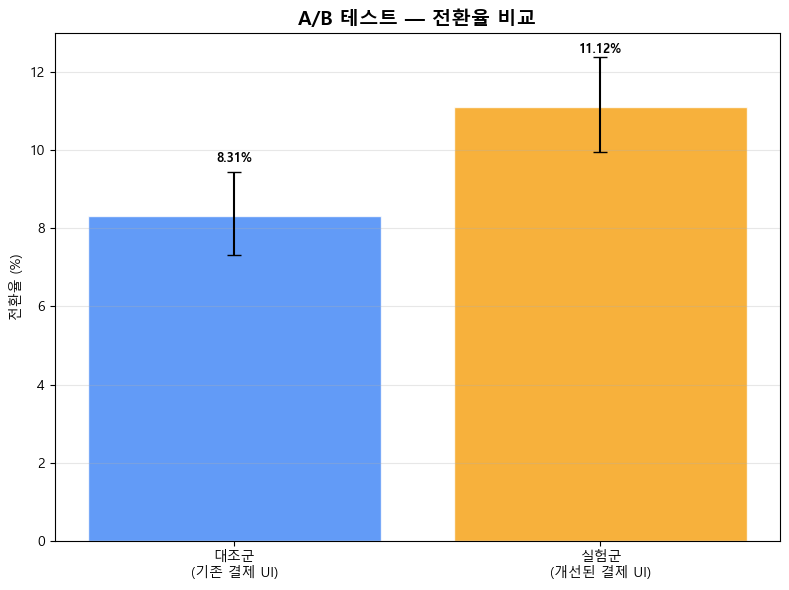

In [37]:
# TODO (g): 전환율 비교 막대 그래프 (신뢰구간 포함)
fig, ax = plt.subplots(figsize=(8, 6))

# TODO: 막대 그래프 그리기
labels = ['대조군\n(기존 결제 UI)', '실험군\n(개선된 결제 UI)']
rates = [cvr_of_control_groups * 100, cvr_of_treatment_groups * 100]
bar_colors = ['#3B82F6', '#F59E0B']
bars = ax.bar(labels, rates, color=bar_colors, alpha=0.8, edgecolor='white')

# 오차막대 (신뢰구간)
cis_low = [ci_low_c * 100, ci_low_t * 100]
cis_upp = [ci_upp_c * 100, ci_upp_t * 100]
yerr_low = [r - l for r, l in zip(rates, cis_low)]
yerr_upp = [u - r for u, r in zip(cis_upp, rates)]

ax.errorbar(labels, rates, 
            yerr=[yerr_low, yerr_upp],
            fmt='none', color='black', capsize=5)

# 전환율 텍스트
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2., rate + 1.3,
            f'{rate:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('전환율 (%)', fontsize=10)
ax.set_title('A/B 테스트 — 전환율 비교', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 3-3: 비즈니스 의사결정

**(a)** A/B 테스트 결과를 종합하여, UI 변경을 **전체 사용자에게 적용할지** 의사결정을 내리세요.
아래 항목을 모두 포함하여 보고서 형식으로 작성하세요.

> | 항목 | 내용 |
> |------|------|
> | 통계적 유의성 | p-value와 유의수준 비교 |
> | 효과크기 | Cohen's h와 해석 |
> | 실무적 의미 | 상대적 개선율과 비즈니스 임팩트 |
> | 신뢰구간 | 비율 차이의 신뢰구간과 두 집단의 신뢰구간 겹침 여부 |
> | 최종 권고 | 적용 / 미적용 / 추가 실험 필요 |

**(b)** 만약 p-value는 유의하지만 효과크기가 매우 작다면(예: Cohen's h < 0.1),
어떤 의사결정이 적절한지 설명하세요.

In [38]:
print("\n[문제 3-3] 비즈니스 의사결정")
print("-" * 40)

# TODO (a): 종합 보고서
print("(a) A/B 테스트 결과 보고서:")

# 통계적 유의성
if z_p < alpha:
    print(f"  [통계적 유의성] p-value({z_p:.4f})가 유의수준({alpha})보다 작으므로 귀무가설을 기각한다.")
else:
    print(f"  [통계적 유의성] p-value({z_p:.4f})가 유의수준({alpha})이상이므로 귀무가설 기각을 보류한다.")


# 효과크기
size_h = '매우 작은' if abs(h) < 0.2 else '작은' if abs(h) < 0.5 else '중간' if abs(h) < 0.8 else '큰'
print(f"\n  [효과크기] Cohen's h = {abs(h):.4f} ({size_h} 효과)")


# 실무적 의미
if relative_lift > 0.001:
    analysis_1 = '기존 전환율 대비 실험군의 전환율이 개선되었다.'
elif abs(relative_lift) < 0.001:
    analysis_1 = '기존 전환율과 실험군의 전환율 차이는 0.001 미만이다.' 
else:
    analysis_1 = '기존 전환율 대비 실험군의 전환율은 오히려 감소하였다.'

if relative_lift > 0.001:
    analysis_2 = '구매 전환율이 개선되면서 소비자 1인당 평균 매출이 증가되는 효과가 기대된다.'     
elif abs(relative_lift) < 0.001:
    analysis_2 = '기존 전환율과 실험군의 전환율 차이는 0.001 미만이므로 결제 화면의 UI 개선을 위한 투자 비용이 낭비된 것으로 사료된다.'
else:
    analysis_2 = '기존 전환율 대비 실험군의 전환율은 오히려 감소하였으므로, 개선된 결제 화면 UI가 오히려 소비자의 불편을 유발했을 가능성이 있다.'

print(f"\n  [실무적 의미] 상대적 개선율이 {relative_lift:.3f} %로, {analysis_1}")
print(f"              따라서 {analysis_2}")


# 신뢰구간 검정
# Q1. 두 집단의 신뢰구간은 겹치는가?
if ci_upp_c >= ci_low_t:
    analysis_3 = '겹친다.'
else:
    analysis_3 = '겹치지 않는다.'
    

# Q2. 두 집단의 비율차이의 신뢰구간은 0을 포함하는가?
if ci_low > 0 or ci_upp < 0:
    analysis_4 = '0을 포함하지 않으므로 두 집단 간 구매 전환율에는 분명한 차이가 있다는 것을 알 수 있다.'
else:
    analysis_4 = '0을 포함하므로 두 집단 간 구매 전환율에는 유의미한 차이가 있으리라 확신할 수 없다.'

print(f"\n  [신뢰구간] 대조군과 실험군의 95% 신뢰구간은 {analysis_3}")
print(f"           두 집단의 구매전환율 차이의 95% 신뢰구간은 {analysis_4}")


# 최종 권고
my_opinion_6 = f"""\n  [최종 권고] 개선된 결제 화면 UI를 적용하기 전에 비용 대비 효과 등을 살펴봐야 한다고 생각한다. 그 이유는 다음과 같다.

  첫째, A/B테스트를 수행하고 진행한 Z-비율검정을 통해 얻은 p-value({z_p:.4f})가 유의수준인 {alpha}보다 작아 귀무가설인 기존 대비 구매 전환율에서는 유의미한 차이가 없다를 기각할 수 있다.
   귀무가설을 기각함으로써 실험군과 대조군의 구매 전환율에는 통계적으로 유의미한 차이가 있을 것으로 보인다.
  둘째, 개선된 결제 화면 UI를 노출한 실험군과 기존 결제 화면 UI를 노출한 대조군 사이에 구매 전환율 차이가 목표 MDE였던 2%p를 달성하였다.
  셋째, 두 집단의 신뢰구간은 서로 겹치지 않고, 두 집단 간의 구매 전환율 차이의 신뢰구간도 0을 포함하지 않는다. 이를 통해 두 집단 간에는 유의한 구매 전환율 차이가 있을 것으로 예상된다.
  넷째, 상대적 개선율을 확인해봤을 때도 상대 개선율은 {relative_lift:.3f}%로 양수이다.

  그러나 효과크기가 {h:.4f}로 매우 작다. 따라서 곧바로 개선된 결제 화면 UI를 전체 사용자에게 적용하는 것보다는 비용 대비 효과를 평가해봐야 한다고 생각한다.
"""

print(my_opinion_6)


[문제 3-3] 비즈니스 의사결정
----------------------------------------
(a) A/B 테스트 결과 보고서:
  [통계적 유의성] p-value(0.0006)가 유의수준(0.05)보다 작으므로 귀무가설을 기각한다.

  [효과크기] Cohen's h = 0.0951 (매우 작은 효과)

  [실무적 의미] 상대적 개선율이 33.796 %로, 기존 전환율 대비 실험군의 전환율이 개선되었다.
              따라서 구매 전환율이 개선되면서 소비자 1인당 평균 매출이 증가되는 효과가 기대된다.

  [신뢰구간] 대조군과 실험군의 95% 신뢰구간은 겹치지 않는다.
           두 집단의 구매전환율 차이의 95% 신뢰구간은 0을 포함하지 않으므로 두 집단 간 구매 전환율에는 분명한 차이가 있다는 것을 알 수 있다.

  [최종 권고] 개선된 결제 화면 UI를 적용하기 전에 비용 대비 효과 등을 살펴봐야 한다고 생각한다. 그 이유는 다음과 같다.

  첫째, A/B테스트를 수행하고 진행한 Z-비율검정을 통해 얻은 p-value(0.0006)가 유의수준인 0.05보다 작아 귀무가설인 기존 대비 구매 전환율에서는 유의미한 차이가 없다를 기각할 수 있다.
   귀무가설을 기각함으로써 실험군과 대조군의 구매 전환율에는 통계적으로 유의미한 차이가 있을 것으로 보인다.
  둘째, 개선된 결제 화면 UI를 노출한 실험군과 기존 결제 화면 UI를 노출한 대조군 사이에 구매 전환율 차이가 목표 MDE였던 2%p를 달성하였다.
  셋째, 두 집단의 신뢰구간은 서로 겹치지 않고, 두 집단 간의 구매 전환율 차이의 신뢰구간도 0을 포함하지 않는다. 이를 통해 두 집단 간에는 유의한 구매 전환율 차이가 있을 것으로 예상된다.
  넷째, 상대적 개선율을 확인해봤을 때도 상대 개선율은 33.796%로 양수이다.

  그러나 효과크기가 -0.0951로 매우 작다. 따라서 곧바로 개선된 결제 화면 UI를 전체 사용자에게 적용하는 것보다는 비용 대비 

In [39]:
# TODO (b): 유의하지만 효과 작은 경우
print(f"\n(b) p 유의 + 효과크기 작은 경우의 의사결정:")
print(f"    이 경우는 현재 갖고 있는 데이터가 해당되는 경우이다. 이러한 경우에는 p-value에 의해 통계적으로 유의한 차이가 있다고 하더라도")
print(f"   더 큰 효과를 낼 수 있는 방안을 새롭게 고안하거나 투자 비용대비 효과를 평가해야 한다고 생각한다.")


(b) p 유의 + 효과크기 작은 경우의 의사결정:
    이 경우는 현재 갖고 있는 데이터가 해당되는 경우이다. 이러한 경우에는 p-value에 의해 통계적으로 유의한 차이가 있다고 하더라도
   더 큰 효과를 낼 수 있는 방안을 새롭게 고안하거나 투자 비용대비 효과를 평가해야 한다고 생각한다.


---

## 문제 4: 학습 앱 A/B 테스트 (연속형 지표 — 학습 시간 비교)

온라인 학습 앱에서 새로운 **게이미피케이션 기능**(배지, 레벨업 시스템)을 도입하면
일일 학습 시간이 늘어나는지 A/B 테스트를 진행합니다.

- **대조군(A)**: 기존 앱 (게이미피케이션 없음)
- **실험군(B)**: 게이미피케이션 도입 버전
- **지표**: 일일 학습 시간 (분)

**분석 목표**: 게이미피케이션 도입이 일일 학습 시간을 유의하게 증가시키는지 검정합니다.

**주어진 데이터:**

In [40]:
print("\n[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교")
print("=" * 50)

np.random.seed(554)
n_ab = 300

# 학습 시간 데이터 (지수분포 — 우측 꼬리가 긴 비대칭 분포)
time_control = np.round(np.random.exponential(scale=25, size=n_ab), 1)    # 대조군: 평균 25분
time_treatment = np.round(np.random.exponential(scale=30, size=n_ab), 1)  # 실험군: 평균 30분

print(f"  대조군 (n={n_ab}): 평균={time_control.mean():.1f}분, 중앙값={np.median(time_control):.1f}분, SD={time_control.std(ddof=1):.1f}분")
print(f"  실험군 (n={n_ab}): 평균={time_treatment.mean():.1f}분, 중앙값={np.median(time_treatment):.1f}분, SD={time_treatment.std(ddof=1):.1f}분")


[문제 4] 학습 앱 A/B 테스트 — 학습 시간 비교
  대조군 (n=300): 평균=25.8분, 중앙값=18.6분, SD=25.2분
  실험군 (n=300): 평균=27.7분, 중앙값=22.6분, SD=24.1분


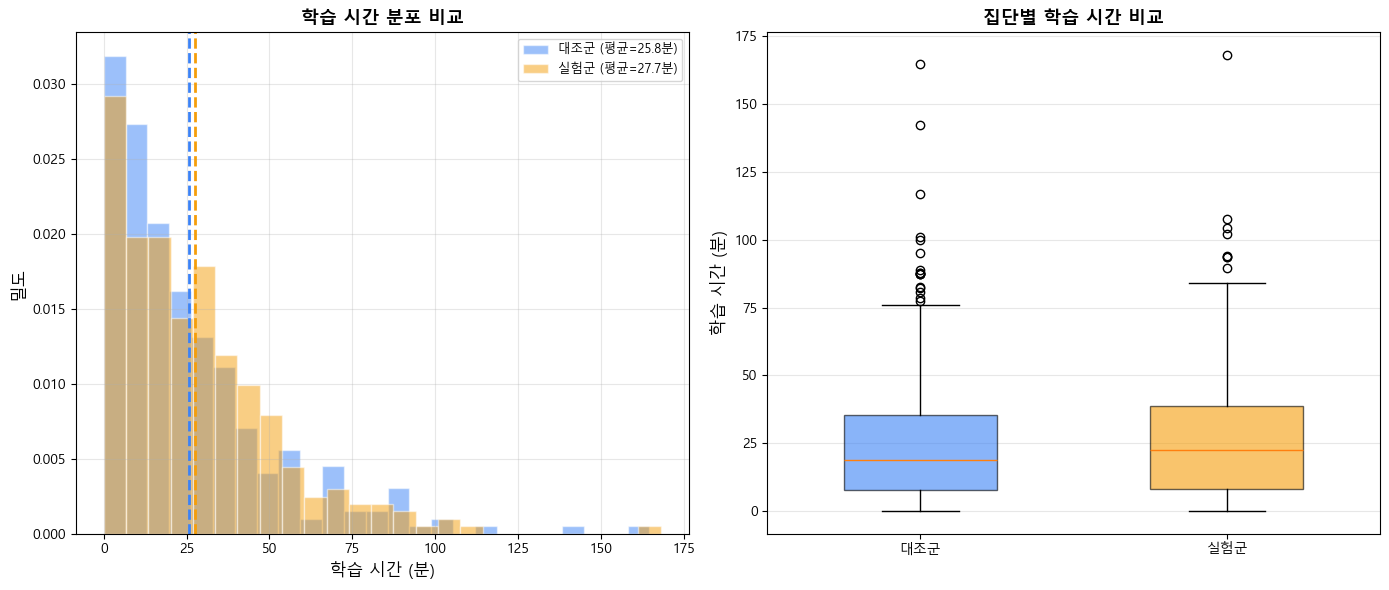

In [41]:
# 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(time_control, bins=25, alpha=0.5, color='#3B82F6', edgecolor='white',
             label=f'대조군 (평균={time_control.mean():.1f}분)', density=True)
axes[0].hist(time_treatment, bins=25, alpha=0.5, color='#F59E0B', edgecolor='white',
             label=f'실험군 (평균={time_treatment.mean():.1f}분)', density=True)
axes[0].axvline(time_control.mean(), color='#3B82F6', linestyle='--', linewidth=2)
axes[0].axvline(time_treatment.mean(), color='#F59E0B', linestyle='--', linewidth=2)
axes[0].set_xlabel('학습 시간 (분)', fontsize=12)
axes[0].set_ylabel('밀도', fontsize=12)
axes[0].set_title('학습 시간 분포 비교', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

bp = axes[1].boxplot([time_control, time_treatment],
                      labels=['대조군', '실험군'],
                      patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3B82F6')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#F59E0B')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('학습 시간 (분)', fontsize=12)
axes[1].set_title('집단별 학습 시간 비교', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 문제 4-1: 정규성 확인과 검정 방법 결정

**(a)** 각 집단의 **정규성 검정**(Shapiro-Wilk)을 수행하세요.

**(b)** 분포의 **왜도(skewness)** 를 계산하세요.

> `from scipy.stats import skew` → `skew(data)`

**(c)** 이 데이터에 t-검정을 적용할 수 있는지 판단하세요.
**중심극한정리(CLT)** 의 관점에서, 표본 크기(n=300)와 왜도를 함께 고려하여 설명하세요.

> | \|skew\| | 분류 | CLT 실무 기준 |
> |:--------:|:---:|:-------------|
> | < 0.5 | 거의 대칭 | n ≥ 15~20이면 충분 |
> | 0.5 ~ 1.0 | 중간 비대칭 | n ≥ 30 권장 |
> | > 1.0 | 강한 비대칭 | n ≥ 100+ 또는 비모수 고려 |

**(d)** 이 데이터에 사용할 **검정 방법**을 결정하세요.
모수 검정(Welch's t)과 비모수 검정(Mann-Whitney U) 중 어떤 것이 적절한지,
또는 **둘 다 수행하여 비교**하는 것이 좋은지 근거를 제시하세요.

In [42]:
print("\n[문제 4-1] 정규성 확인과 검정 방법 결정")
print("-" * 40)

# TODO (a): 정규성 검정
print("(a): Shapiro-Wilk 정규성 검정 결과")
print("-" * 40)

shapiro_stat_c, shapiro_p_c = stats.shapiro(time_control) # 대조군(c)
shapiro_stat_t, shapiro_p_t = stats.shapiro(time_treatment) # 실험군(t)

print(f" 대조군의 Shapiro-Wilk 검정통계량: {shapiro_stat_c:.4f}, p-value: {shapiro_p_c:.4e}")
if shapiro_p_c > 0.05:
    print(" 대조군: 귀무가설을 기각하지 못합니다. -> 정규성을 만족한 것으로 인정합니다.")
else:
    print(" 대조군: 귀무가설을 기각합니다. -> 정규성을 만족하지 못합니다.")

print(f"\n 실험군의 Shapiro-Wilk 검정통계량: {shapiro_stat_t:.4f}, p-value: {shapiro_p_t:.4e}")
    
if shapiro_p_t > 0.05:
    print(" 실험군: 귀무가설을 기각하지 못합니다. -> 정규성을 만족한 것으로 인정합니다.")
else:
    print(" 실험군: 귀무가설을 기각합니다. -> 정규성을 만족하지 못합니다.")




[문제 4-1] 정규성 확인과 검정 방법 결정
----------------------------------------
(a): Shapiro-Wilk 정규성 검정 결과
----------------------------------------
 대조군의 Shapiro-Wilk 검정통계량: 0.8258, p-value: 1.0920e-17
 대조군: 귀무가설을 기각합니다. -> 정규성을 만족하지 못합니다.

 실험군의 Shapiro-Wilk 검정통계량: 0.8786, p-value: 1.1315e-14
 실험군: 귀무가설을 기각합니다. -> 정규성을 만족하지 못합니다.


In [43]:
# TODO (b): 왜도
print("(b): 왜도 계산 결과")
print("-" * 40)

skew_c = skew(time_control) # 대조군(c)
skew_t = skew(time_treatment) # 실험군(t)

print(f"대조군의 왜도: {skew_c:.4f}")
print(f"실험군의 왜도: {skew_t:.4f}")


(b): 왜도 계산 결과
----------------------------------------
대조군의 왜도: 1.8458
실험군의 왜도: 1.5407


In [44]:
# TODO (c): CLT 판단
print("(c): CLT 판단")
print("-" * 40)

my_opinion_7 = f""" 대조군의 왜도는 {skew_c:.4f}이고, 실험군의 왜도는 {skew_t:.4f}으로 두 집단의 왜도는 모두 1보다 큰 절댓값을 갖는다.
따라서 강한 비대칭 분포를 갖고 있다고 할 수 있지만, 표본크기가 300으로 CLT의 실무적 판단 기준에 따르면 우리가 만든 표본의 표본평균은 정규분포에 근사한다고 볼 수 있다.
따라서 두 집단의 표본평균 비교에 t-검정을 사용할 수 있을 것으로 사료된다. 
"""

print(my_opinion_7)

(c): CLT 판단
----------------------------------------
 대조군의 왜도는 1.8458이고, 실험군의 왜도는 1.5407으로 두 집단의 왜도는 모두 1보다 큰 절댓값을 갖는다.
따라서 강한 비대칭 분포를 갖고 있다고 할 수 있지만, 표본크기가 300으로 CLT의 실무적 판단 기준에 따르면 우리가 만든 표본의 표본평균은 정규분포에 근사한다고 볼 수 있다.
따라서 두 집단의 표본평균 비교에 t-검정을 사용할 수 있을 것으로 사료된다. 



In [45]:
# TODO (d): 검정 방법 결정
print("(d): 검정 방법 결정")
print("-" * 40)

my_opinion_8 = f""" CLT의 실무적 기준에 따라 표본크기가 300으로 충분히 크기 때문에 강한 비대칭 분포를 가진 데이터임에도 불구하고,
표본평균은 정규분포에 근사한다고 판단하고, Welch's t-검정을 고려할 수 있다. 그러나 두 집단 모두 극단값이 존재하는 데이터를 갖고 있기 때문에
중앙값을 기반으로 하는 Mann-Whitney U 검정을 함께 수행한 뒤, 두 검정의 결과를 비교하고자 한다.
"""

print(my_opinion_8)

(d): 검정 방법 결정
----------------------------------------
 CLT의 실무적 기준에 따라 표본크기가 300으로 충분히 크기 때문에 강한 비대칭 분포를 가진 데이터임에도 불구하고,
표본평균은 정규분포에 근사한다고 판단하고, Welch's t-검정을 고려할 수 있다. 그러나 두 집단 모두 극단값이 존재하는 데이터를 갖고 있기 때문에
중앙값을 기반으로 하는 Mann-Whitney U 검정을 함께 수행한 뒤, 두 검정의 결과를 비교하고자 한다.



### 문제 4-2: 검정 수행 및 효과크기

**(a)** **Welch's t-검정**을 수행하세요 (pingouin의 `pg.ttest()` 사용).

> `pg.ttest(x, y, alternative='two-sided')` → T, p-val, cohen-d, CI95%, BF10, power 제공

**(b)** **Mann-Whitney U 검정**을 수행하세요 (pingouin의 `pg.mwu()` 사용).

> `pg.mwu(x, y, alternative='two-sided')` → U-val, p-val, RBC, CLES 제공

**(c)** 두 검정의 결과를 비교하세요. 결론이 같은가요, 다른가요?
왜 같은/다른 결론이 나오는지 데이터의 특성(분포, 표본 크기)과 연결하여 설명하세요.

**(d)** 검정 결과를 종합하여, 게이미피케이션 도입의 효과에 대한 최종 결론을 내리세요.
통계적 유의성, 효과크기, 상대적 개선율을 모두 포함하세요.

In [46]:
print("\n[문제 4-2] 검정 수행 및 효과크기")
print("-" * 40)

# TODO (a): Welch's t-검정 (pingouin)
print("(a): Welch's t-검정 수행 결과")
print("-" * 40)

welchs_t_result = pg.ttest(time_treatment,time_control, alternative='two-sided')

display(welchs_t_result)


[문제 4-2] 검정 수행 및 효과크기
----------------------------------------
(a): Welch's t-검정 수행 결과
----------------------------------------


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.919348,598,two-sided,0.358284,"[-2.1, 5.81]",0.075064,0.137,0.150687


In [47]:
# TODO (b): Mann-Whitney U 검정 (pingouin)
print("(b): Mann-Whitney U 검정 수행 결과")
print("-" * 40)

mwu_result = pg.mwu(time_treatment,time_control, alternative='two-sided')

display(mwu_result)

(b): Mann-Whitney U 검정 수행 결과
----------------------------------------


,U-val,alternative,p-val,RBC,CLES
MWU,48086.5,two-sided,0.14607,0.068589,0.534294


In [48]:
# TODO (c): 두 검정 비교
print("(c): 두 검정방법 비교")
print("-" * 40)

my_opinion_9 = f"""유의수준을 0.05라고 가정하자.
Welch's t 검정의 p-value는 {welchs_t_result['p-val'].values[0]:.4f}로 유의수준보다 커 귀무가설 기각을 보류해야 한다는 결론을 내릴 수 있다.
Mann-Whitney U 검정의 p-value는 {mwu_result['p-val'].values[0]:.4f}로 유의수준보다 크므로 귀무가설 기각을 보류해야 한다는 결론을 내릴 수 있다.
따라서 두 검정을 각각 수행하더라도'귀무가설 기각을 보류한다'는 같은 결론을 내릴 수 있다. 그렇다면 두 검정 결과를 통해 같은 결론을 내릴 수 있던 이유는 무엇일까?

그것은 대조군과 실험군의 데이터는 모두 비대칭적인 분포를 갖고 있음에도 불구하고, 표본크기가 300개로 충분히 크기 때문일 것이다.
데이터 분포가 비대칭적이더라도 표본크기가 충분히 크면 표본평균의 분포는 정규분포에 근사되기 때문에 t-검정 방법으로 수행하더라도 동일한 결론을 얻을 수 있었다고 생각한다.

단, 동일한 결론을 얻었음에도 불구하고 분명 각각의 검정을 수행함으로써 얻은 결과에는 차이가 있다. 
먼저 Welch's t 검정은 극단값의 영향을 받는 평균을 활용하기 때문에 p-value가 상대적으로 크게 나온 것으로 예상된다.
그러나 Mann-Whitney U 검정은 극단값의 영향을 덜 받는 순위 기반의 검정방법이기 때문에 p-value가 상대적으로 작게 나온 것으로 보인다. 
"""

print(my_opinion_9)

(c): 두 검정방법 비교
----------------------------------------
유의수준을 0.05라고 가정하자.
Welch's t 검정의 p-value는 0.3583로 유의수준보다 커 귀무가설 기각을 보류해야 한다는 결론을 내릴 수 있다.
Mann-Whitney U 검정의 p-value는 0.1461로 유의수준보다 크므로 귀무가설 기각을 보류해야 한다는 결론을 내릴 수 있다.
따라서 두 검정을 각각 수행하더라도'귀무가설 기각을 보류한다'는 같은 결론을 내릴 수 있다. 그렇다면 두 검정 결과를 통해 같은 결론을 내릴 수 있던 이유는 무엇일까?

그것은 대조군과 실험군의 데이터는 모두 비대칭적인 분포를 갖고 있음에도 불구하고, 표본크기가 300개로 충분히 크기 때문일 것이다.
데이터 분포가 비대칭적이더라도 표본크기가 충분히 크면 표본평균의 분포는 정규분포에 근사되기 때문에 t-검정 방법으로 수행하더라도 동일한 결론을 얻을 수 있었다고 생각한다.

단, 동일한 결론을 얻었음에도 불구하고 분명 각각의 검정을 수행함으로써 얻은 결과에는 차이가 있다. 
먼저 Welch's t 검정은 극단값의 영향을 받는 평균을 활용하기 때문에 p-value가 상대적으로 크게 나온 것으로 예상된다.
그러나 Mann-Whitney U 검정은 극단값의 영향을 덜 받는 순위 기반의 검정방법이기 때문에 p-value가 상대적으로 작게 나온 것으로 보인다. 



In [ ]:
# TODO (d): 최종 결론

# 상대적 개선율 = (실험군 평균 - 대조군 평균) / 대조군 평균 × 100
relative_lift_time = (time_treatment.mean()-time_control.mean()) / time_control.mean() *100

print("최종 결론을 도출하기 위해 필요한 지표")
print("-" * 40)
print(f"(1) Welch's t 검정의 p-value: {welchs_t_result['p-val'].values[0]:.4f}") # 0.3583
print(f"(2) Mann-Whitney U 검정의 p-value: {mwu_result['p-val'].values[0]:.4f}") # 0.1461
print(f"(3) 효과크기(Cohen's d): {welchs_t_result['cohen-d'].values[0]:.4f}") # 0.0751
print(f"(4) 게이미피케이션 도입 후, 일일 학습시간의 상대적 개선율: {relative_lift_time:.4f}%") # 7.1781 %

print("-" * 40)
print("(d): 최종 결론")
print("-" * 40)

my_opinion_10 = f"""이번 분석의 목표는 게이미피케이션 도입이 일일 학습 시간을 유의하게 증가시키는지를 검정하는 것이다.
따라서 분석 목적에 따라 설정한 귀무가설과 대립가설은 다음과 같다.

  - 귀무가설(H₀): 게이미피케이션 도입이 일일 학습 시간에 유의한 차이가 없다.
  - 대립가설(H₁): 게이미피케이션 도입이 일일 학습 시간에 유의한 차이가 있다.

Welch's t 검정, Mann-Whitney U 검정을 모두 수행해 p-value를 확인한 결과, 각각 {welchs_t_result['p-val'].values[0]:.4f}, 
{mwu_result['p-val'].values[0]:.4f}로 통상적 유의수준인 0.05보다 크다. 따라서 귀무가설을 기각하는 것은 보류되기 때문에 게이미피케이션 도입이
일일 학습 시간에 유의미한 차이를 만들었다는 것을 입증하지 못했다.
또한, 효과크기도 {welchs_t_result['cohen-d'].values[0]:.4f}로 매우 작은 수준이기 때문에 효과가 있다고 하더라도 미미한 수준일 것으로 예상된다.
게이미피케이션 도입 후, 일일 학습시간의 상대적 개선율을 확인해봤을 때 {relative_lift_time:.4f}%로 개선이 된 것으로 보이긴 하지만, 이 또한 귀무가설을 기각하지 못하는
현재 상황에서는 우연에 의한 차이일 수 있다는 것을 배제할 수 없다.

따라서 게이미피케이션 도입을 보류하고, 더 큰 효과를 낼 수 있는 방안을 찾거나 추가 실험을 진행할 필요가 있다고 생각한다.

"""

print(my_opinion_10)

최종 결론을 도출하기 위해 필요한 지표
----------------------------------------
(1) Welch's t 검정의 p-value: 0.3583
(2) Mann-Whitney U 검정의 p-value: 0.1461
(3) 효과크기(Cohen's d): 0.0751
(4) 게이미피케이션 도입 후, 일일 학습시간의 상대적 개선율: 7.1781%
----------------------------------------
(d): 최종 결론
----------------------------------------
이번 분석의 목표는 게이미피케이션 도입이 일일 학습 시간을 유의하게 증가시키는지를 검정하는 것이다.
따라서 분석 목적에 따라 설정한 귀무가설과 대립가설은 다음과 같다.

  - 귀무가설(H₀): 게이미피케이션 도입이 일일 학습 시간에 유의한 차이가 없다.
  - 대립가설(H₁): 게이미피케이션 도입이 일일 학습 시간에 유의한 차이가 있다.

Welch's t 검정, Mann-Whitney U 검정을 모두 수행해 p-value를 확인한 결과, 각각 0.3583, 
0.1461로 통상적 유의수준인 0.05보다 크다. 따라서 귀무가설을 기각하는 것은 보류되기 때문에 게이미피케이션 도입이
일일 학습 시간에 유의미한 차이를 만들었다는 것을 입증하지 못했다.
또한, 효과크기도 0.0751로 매우 작은 수준이기 때문에 효과가 있다고 하더라도 미미한 수준일 것으로 예상된다.
게이미피케이션 도입 후, 일일 학습시간의 상대적 개션율을 확인해봤을 때 7.1781%로 개선이 된 것으로 보이긴 하지만, 이 또한 귀무가설을 기각하지 못하는
현재 상황에서는 우연에 의한 차이일 수 있다는 것을 배제할 수 없다.

따라서 게이미피케이션 도입을 보류하고, 더 큰 효과를 낼 수 있는 방안을 찾거나 추가 실험을 진행할 필요가 있다고 생각한다.


